###Convolution Autoencoder for MaNGA Kinematic Maps

This is the second notebook in the series for unsupervised learning.
This notebook will look at a CNN autoencoder, the purpose of which is to grab relevant information from kinematic maps and then the lower-dimensional parameter space can be used to do clustering.

In [23]:

import matplotlib.pyplot as plt
import numpy as np
import marvin
from marvin import config, marvindb
# Again, if this doesn't work, go read these instructions on setting it up - https://github.com/sdss/marvin
from marvin.tools.maps import Maps
import pyfits
import os
from marvin.tools.query import Query
from sh import gunzip
from marvin.utils.general import downloadList
import random
import re
from astropy.io import fits


%matplotlib inline

config.access = 'collab'#'collab' if collab
# Option to choose the data release you would like to use:
config.setRelease('MPL-8')#MPL-8 if public
print('Access is',config.access)

# Okay so now that you have downloaded everything it is time to search through your directory for maps
# and assembly a list of existing data in order to run an analysis



# You can also use os to get you the names of all directories in a folder
#print(os.listdir())
# This will yield a tuple for each subdirectory. Ths first entry in the 3-tuple is a directory name, so:

plates = [x[0] for x in os.walk('/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/')]




existing_plateifus=[]

for j in range(len(plates)):
    if re.split('/',plates[j])[-2]=='VOR10-MILESHC-MILESHC':# or re.split('/',plates[j])[-1] != '12701':
        continue
    else:
        existing_plateifus.append(str(re.split('/',plates[j])[-2])+'-'+str(re.split('/',plates[j])[-1]))
#print(existing_plateifus)
print('this is how many galaxies you are working with (that exist on your computer)', len(existing_plateifus))
# Now you need to construct plateifu names of what exists

Access is collab
this is how many galaxies you are working with (that exist on your computer) 1046


In [7]:
# I'm running into a weird limit error code:
# OSError: [Errno 24] Too many open files
import resource
print(resource.getrlimit(resource.RLIMIT_NOFILE))
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

(10000, 9223372036854775807)


This next section goes about building the map_array_ml, which contains all of the galaxies.

In [8]:

# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = np.shape(Maps(existing_plateifus[0])['stellar_vel'].value)[1]
shape = 76 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(existing_plateifus),shape**2))#np.zeros((len(plateifu_list),74**2))
ifu_name=[]
counter=0
for j in range(len(existing_plateifus)):
    '''print('existing_plateifus', existing_plateifus[j])
    print(str(re.split('-',existing_plateifus[j])[-2])+'-'+str(re.split('-',existing_plateifus[j])[-1]))
    print(str(re.split('-',existing_plateifus[j])[-2]))
    if j > 2:
        STOP'''
    try:
        mapit = Maps(filename='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(re.split('-',existing_plateifus[j])[-2])+'/'+str(re.split('-',existing_plateifus[j])[-1])+'/manga-'+existing_plateifus[j]+'-MAPS-VOR10-MILESHC-MILESHC.fits')['stellar_vel'].value
    except:
        mapit = Maps(filename='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(re.split('-',existing_plateifus[j])[-2])+'/'+str(re.split('-',existing_plateifus[j])[-1])+'/manga-'+existing_plateifus[j]+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz')['stellar_vel'].value
     
    #mapit = Maps(existing_plateifus[j], mode='local', bintype='VOR10', data_origin='db')['stellar_vel'].value
    
    #if plateifu_list[j][-5:-1]=='1270':
        
    try:
        map_array.append(mapit)
        shape_here = int(np.sqrt(np.shape(mapit)[0]))
        
        
        map_array_ml[j,:] = np.reshape(mapit,(shape**2))
        
        '''plt.clf()
        plt.imshow(Maps(existing_plateifus[j])['stellar_vel'].value)
        plt.colorbar()
        plt.show()
        print(np.shape(Maps(existing_plateifus[j])['stellar_vel'].value), shape)'''
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(mapit)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(mapit, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            print('cannot pad')
            plt.clf()
            plt.imshow(mapit)
            plt.colorbar()
            plt.show()
            print(np.shape(mapit), shape)
            STOP
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    ifu_name.append(existing_plateifus[j])
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

What if I instead want to play with existing kin maps (that I have de-rotated)?


In [41]:
plates = [x[2] for x in os.walk('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/')][0]
print('total number of kin maps', len(plates))
# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = 76 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(plates),shape**2))#np.zeros((len(plateifu_list),74**2))
ifu_name=[]
counter=0
for j in range(len(plates)):
     
    mapkin = fits.open('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/'+plates[j])
    mapit = np.array(np.ma.masked_where(mapkin[2].data==0.0, mapkin[2].data))
    '''plt.imshow(np.ma.masked_where(mapit[2].data==0.0, mapit[2].data), 
               vmin=-100, vmax=100, cmap='RdBu_r')
    plt.colorbar()
    plt.show()
    STOP'''
    try:
        map_array_ml[j,:] = np.reshape(mapit,(shape**2))

    
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(mapit)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(mapit, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            print('cannot pad')
            plt.clf()
            plt.imshow(mapit)
            plt.colorbar()
            plt.show()
            print(np.shape(mapit), shape)
            STOP
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    ifu_name.append(existing_plateifus[j])
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.


total number of kin maps 1043


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8155-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8997-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8328-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8600-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7993-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9883-3701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8938-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8079-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8603-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9488-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8439-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8134-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10508-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8252-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9185-9101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8944-6103.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9874-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9499-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9511-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8615-1901.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8085-9102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9864-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9888-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8588-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8567-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7975-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10218-9102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8464-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7968-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9038-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8082-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8615-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8728-1901.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9192-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8941-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9044-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8322-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8947-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8713-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7977-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8455-1902.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9037-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10220-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9498-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8462-9101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8459-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10220-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9498-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8723-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8482-3702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8618-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8623-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8992-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9085-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8258-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8249-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8247-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10507-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8626-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8144-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8939-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8443-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7992-3701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8447-3702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9883-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8611-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9874-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10509-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9871-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8315-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8247-1902.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8948-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

['9036-3701', '9036-12703', '9036-12705', '7990-12705', '7990-12702', '7990-12701', '8322-6102', '8322-1901', '7964-12703', '7964-12704', '7964-12705', '7964-12702', '7964-12701', '7964-3703', '9499-12703', '9499-12704', '9499-6103', '8325-12703', '8325-12705', '8325-12702', '9031-12703', '9031-12704', '9031-12705', '9031-12702', '9031-12701', '9497-12704', '9497-12701', '8313-12703', '8313-6102', '9038-12704', '9038-12702', '9000-12703', '9000-12704', '9000-12705', '9000-3702', '9000-12701', '9000-3704', '9490-3701', '8985-6103', '8985-12701', '10497-6104', '9868-1901', '8724-12703', '8982-6102', '8723-6104', '8723-3702', '8723-6101', '8949-12703', '8949-12705', '8949-6101', '9892-6104', '9892-6101', '8940-12703', '8940-12704', '8940-12705', '8940-12702', '8940-12701', '9091-3703', '8143-1902', '8143-3704', '8715-12703', '8715-6103', '8715-12701', '8947-12703', '8947-12704', '8947-12705', '8947-12702', '8947-6104', '8712-6103', '8712-6102', '8144-12703', '8144-12704', '8144-12702', '8

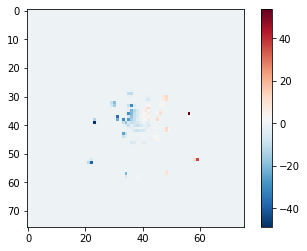

In [42]:
# This is how many galaxies you have in your map_array_ml cube
print(ifu_name)
print(len(ifu_name))


# To prepare the map cube (map_array_ml) for ML algorithms,
# it is necessary to first cut off all the empty rows.

# Removing all rows that were not filled (above)
data = map_array_ml[~np.all(map_array_ml == 0, axis=1)]
#print(np.shape(data))
plt.imshow(np.reshape(data[66], (76,76)), cmap='RdBu_r')
plt.colorbar()
plt.show()
data_length = np.shape(data)[0]
map_array_ml = data

size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
#map_array_ml = np.ma.masked_where(data==0., data)

In [43]:
# Maybe unflatten it first?
full_data = np.reshape(map_array_ml,(np.shape(map_array_ml)[0],shape,shape))

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(full_data, test_size=0.1, random_state=42)

/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [44]:
print(np.shape(X_train), np.shape(X_test))

(938, 76, 76) (105, 76, 76)


In [45]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

Using TensorFlow backend.
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap_external.py:525: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps/8155-12701.fits' mode='rb' closefd=True>
  code = marshal.loads(data)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap_external.py:525: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8155-12701.fits' mode='rb' clos

In [46]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = full_data.shape[1:]

encoder, decoder = build_autoencoder(IMG_SHAPE, 320)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 76, 76)            0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 320)               1848640   
_________________________________________________________________
sequential_2 (Sequential)    (None, 76, 76)            1854096   
Total params: 3,702,736
Trainable params: 3,702,736
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])


Train on 938 samples, validate on 105 samples
Epoch 1/20
938/938 [==============================] - 1s 2ms/step - loss: 355.8477 - val_loss: 239.9734
Epoch 2/20
938/938 [==============================] - 1s 848us/step - loss: 261.4456 - val_loss: 239.1639
Epoch 3/20
938/938 [==============================] - 1s 840us/step - loss: 236.2886 - val_loss: 215.5213
Epoch 4/20
938/938 [==============================] - 1s 848us/step - loss: 173.3186 - val_loss: 197.4163
Epoch 5/20
938/938 [==============================] - 1s 808us/step - loss: 144.4218 - val_loss: 190.5900
Epoch 6/20
938/938 [==============================] - 1s 837us/step - loss: 135.8073 - val_loss: 186.9636
Epoch 7/20
938/938 [==============================] - 1s 843us/step - loss: 124.6571 - val_loss: 183.6205
Epoch 8/20
938/938 [==============================] - 1s 861us/step - loss: 111.4252 - val_loss: 180.9325
Epoch 9/20
938/938 [==============================] - 1s 844us/step - loss: 114.1383 - val_loss: 176.3153
E

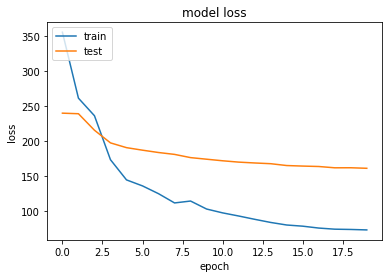

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(76, 76)


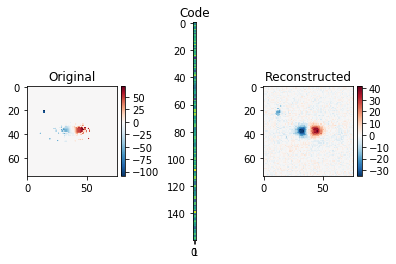

(76, 76)


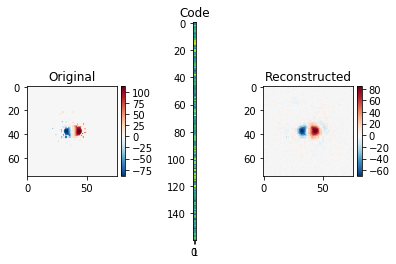

(76, 76)


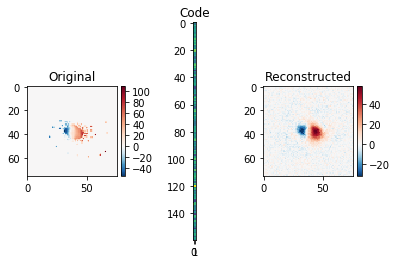

(76, 76)


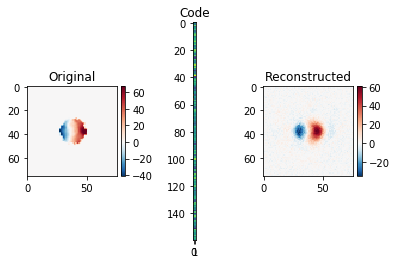

(76, 76)


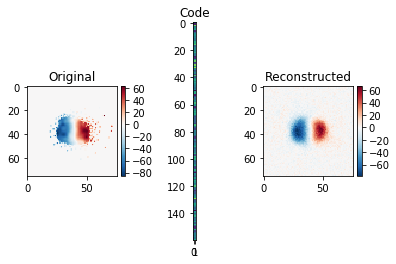

(76, 76)


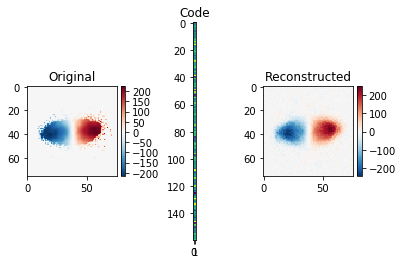

(76, 76)


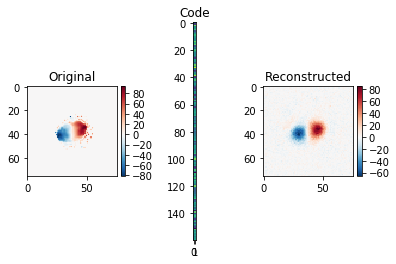

(76, 76)


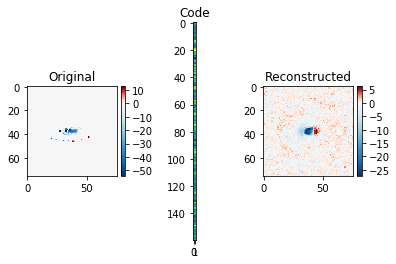

(76, 76)


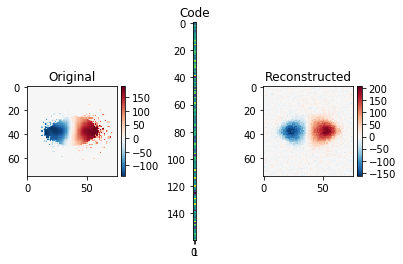

(76, 76)


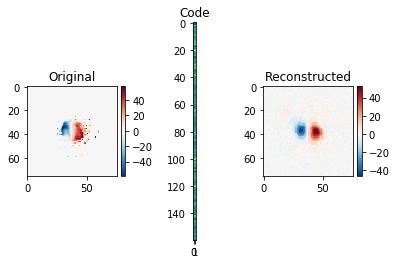

(76, 76)


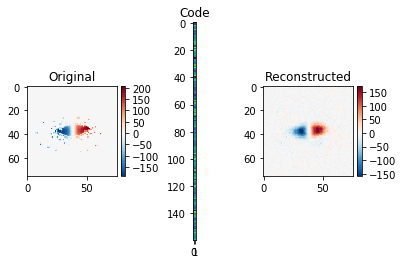

(76, 76)


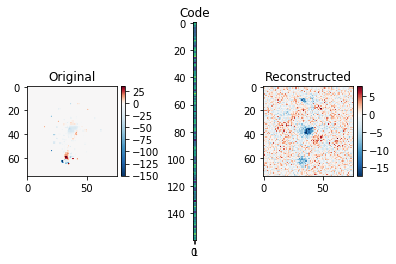

(76, 76)


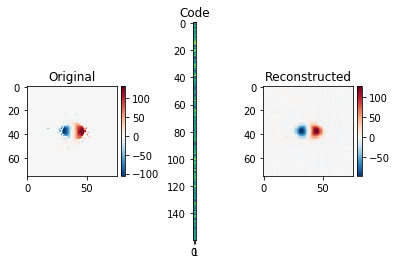

(76, 76)


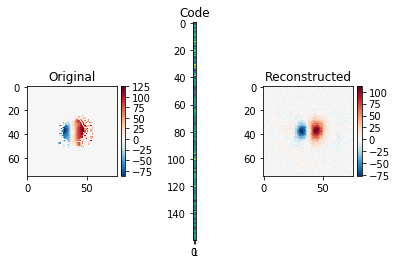

(76, 76)


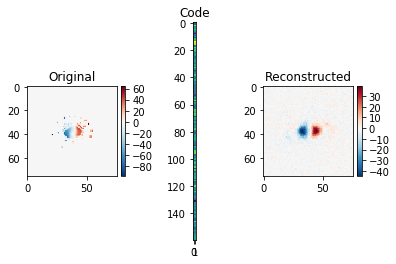

(76, 76)


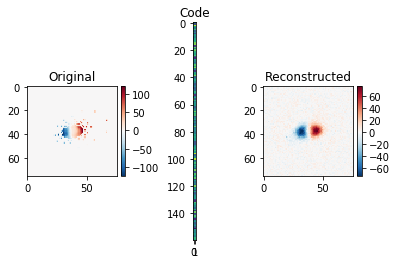

(76, 76)


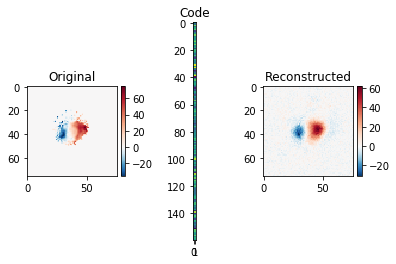

(76, 76)


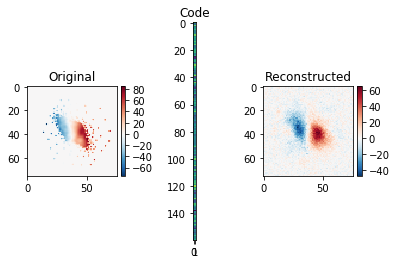

(76, 76)


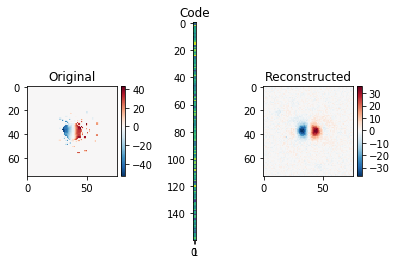

(76, 76)


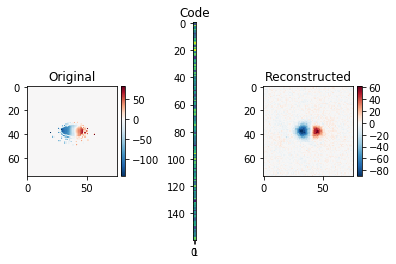

(76, 76)


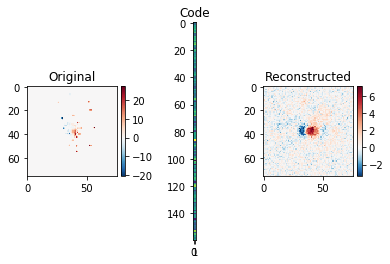

(76, 76)


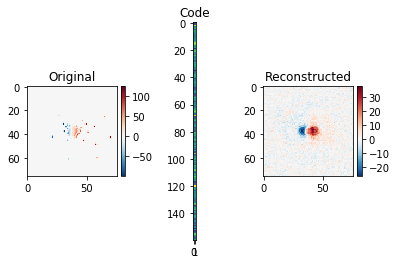

(76, 76)


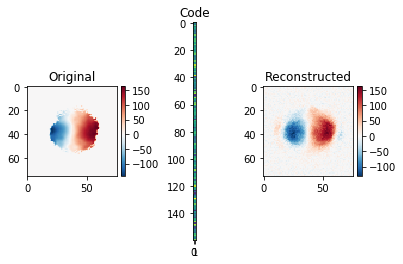

(76, 76)


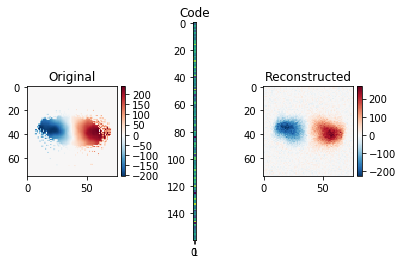

(76, 76)


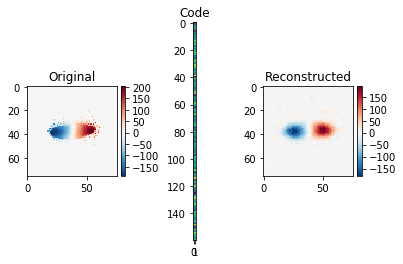

(76, 76)


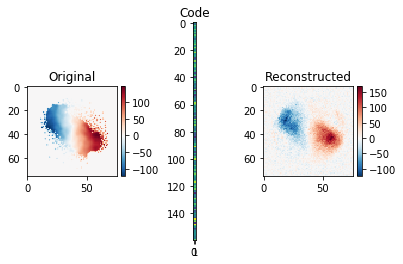

(76, 76)


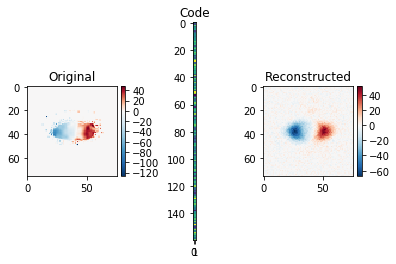

(76, 76)


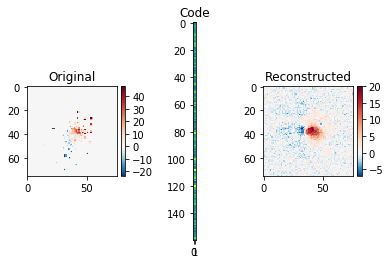

(76, 76)


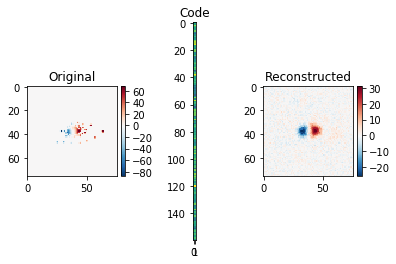

(76, 76)


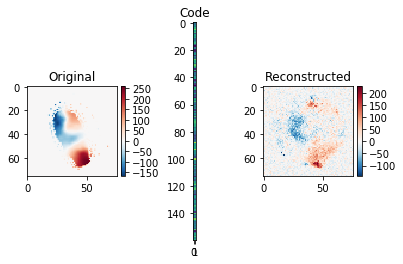

(76, 76)


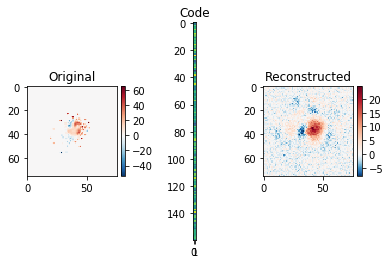

(76, 76)


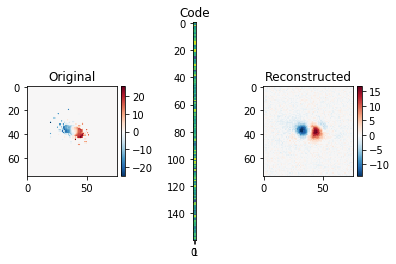

(76, 76)


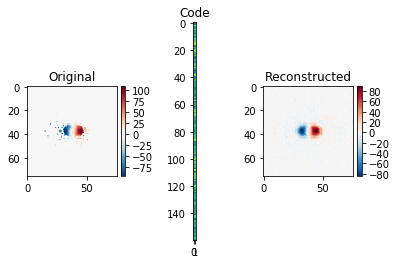

(76, 76)


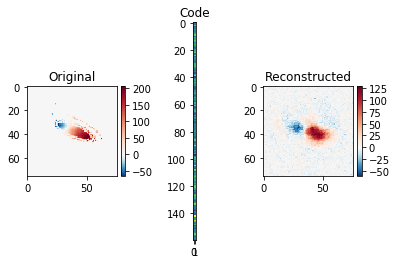

(76, 76)


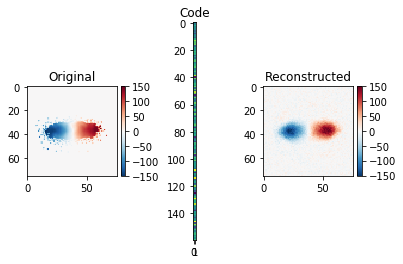

(76, 76)


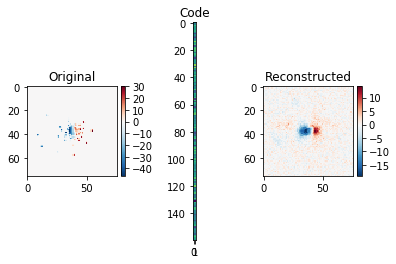

(76, 76)


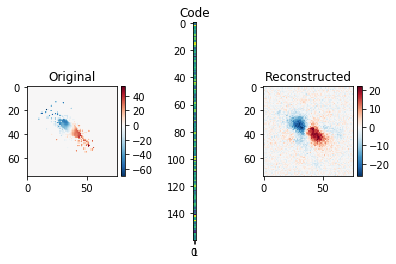

(76, 76)


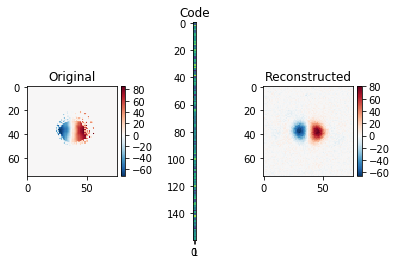

(76, 76)


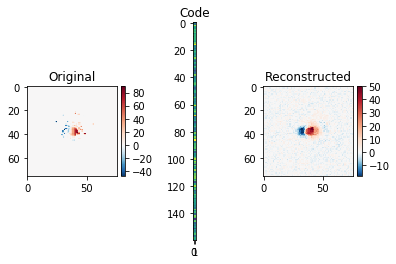

(76, 76)


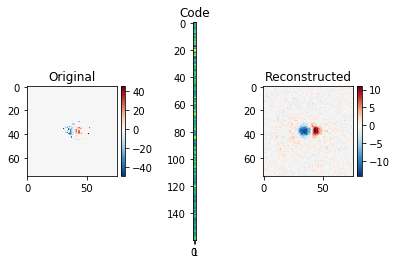

(76, 76)


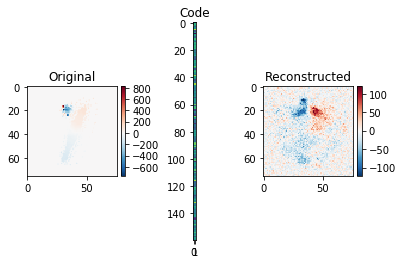

(76, 76)


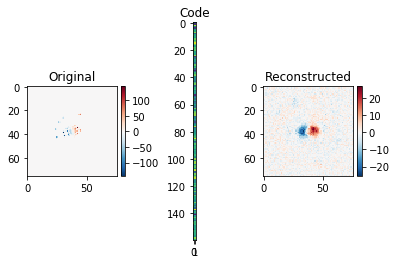

(76, 76)


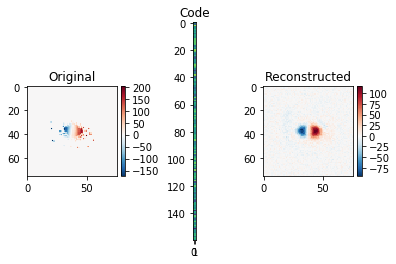

(76, 76)


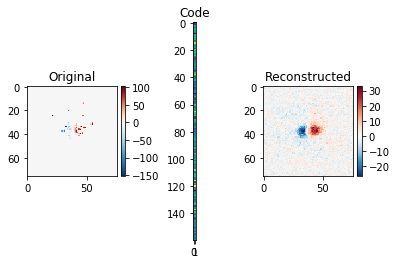

(76, 76)


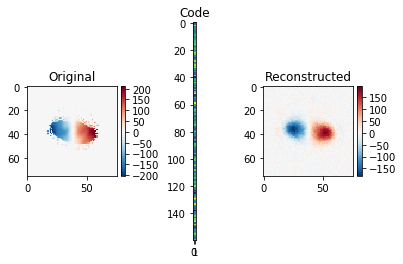

(76, 76)


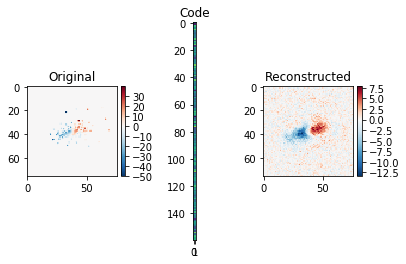

(76, 76)


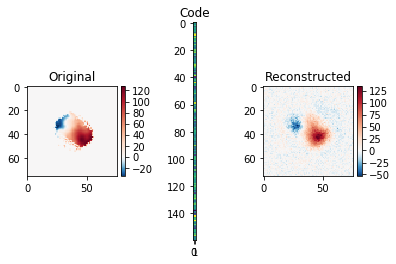

(76, 76)


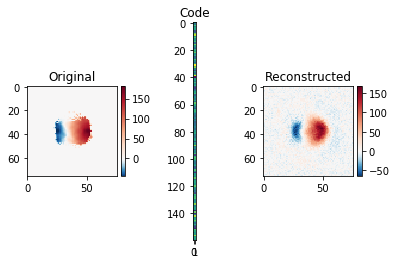

(76, 76)


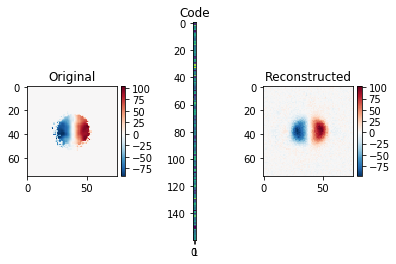

(76, 76)


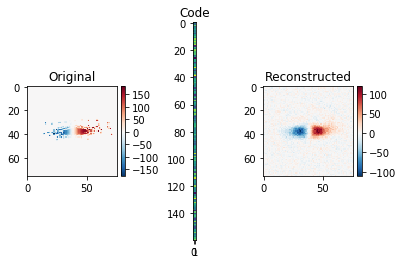

(76, 76)


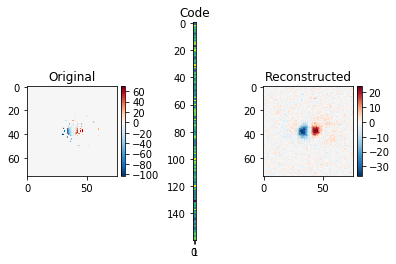

(76, 76)


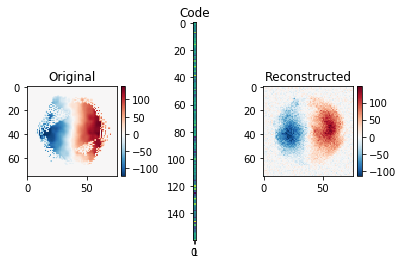

(76, 76)


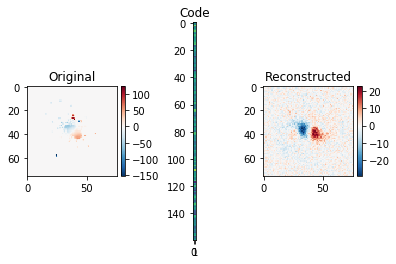

(76, 76)


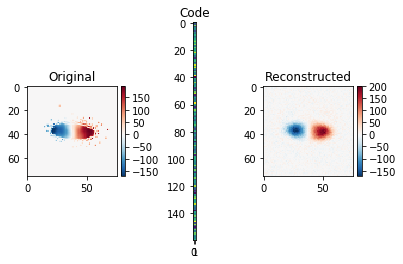

(76, 76)


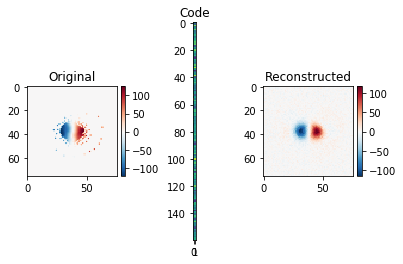

(76, 76)


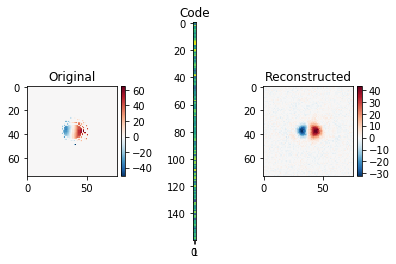

(76, 76)


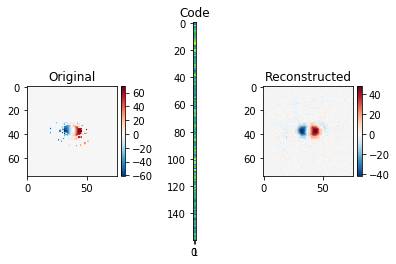

(76, 76)


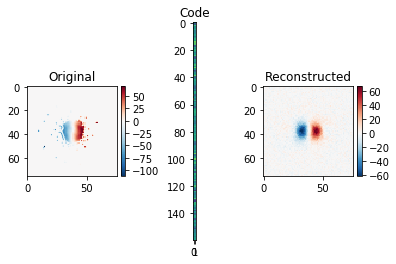

(76, 76)


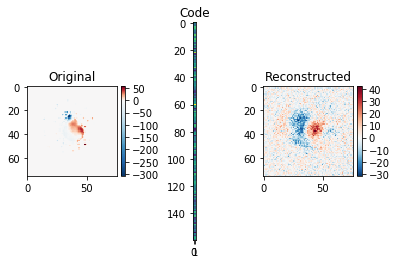

(76, 76)


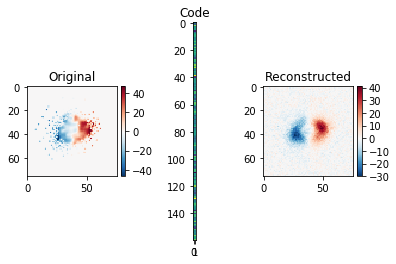

(76, 76)


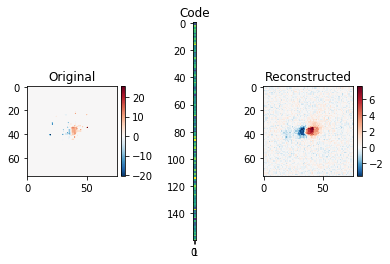

(76, 76)


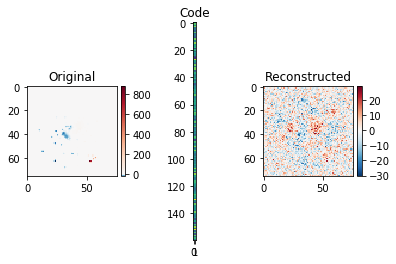

(76, 76)


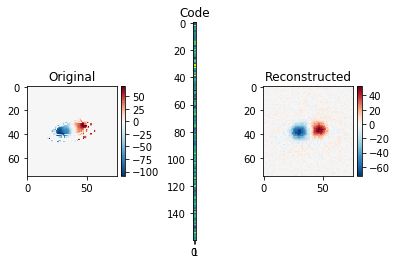

(76, 76)


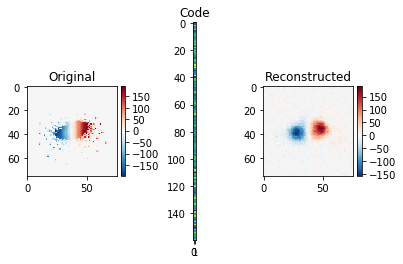

(76, 76)


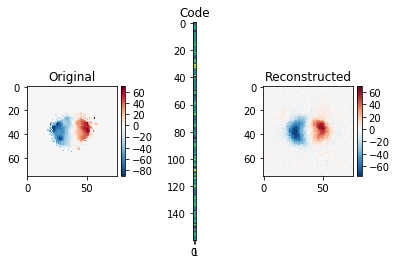

(76, 76)


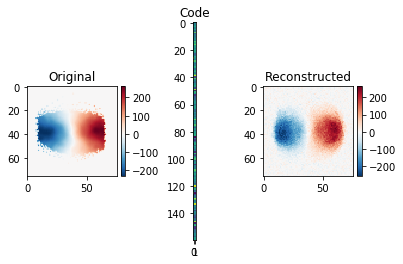

(76, 76)


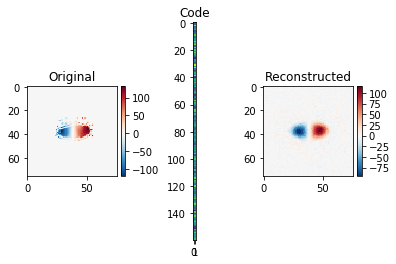

(76, 76)


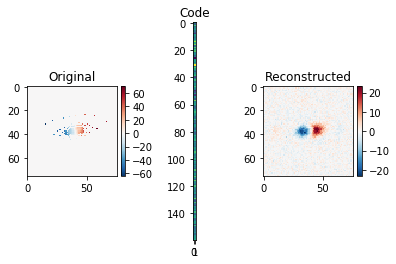

(76, 76)


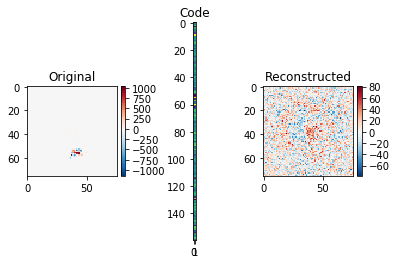

(76, 76)


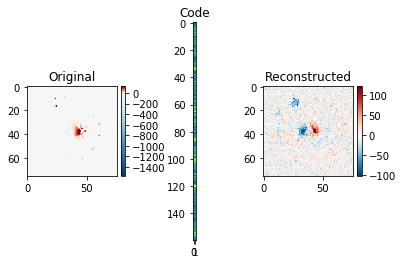

(76, 76)


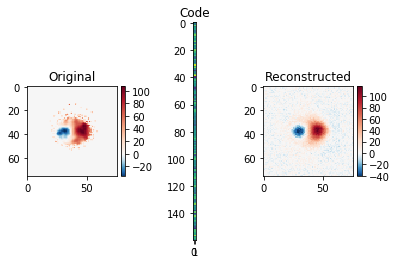

(76, 76)


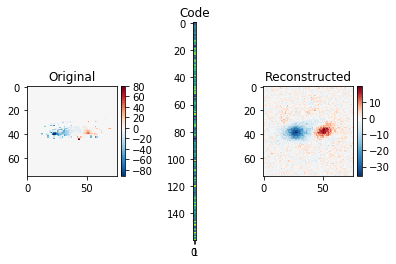

(76, 76)


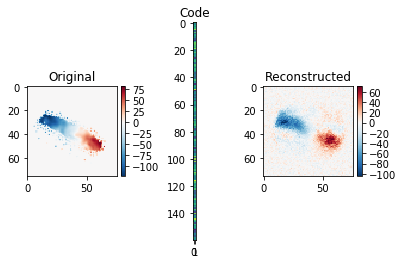

(76, 76)


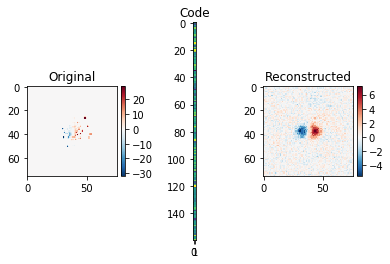

(76, 76)


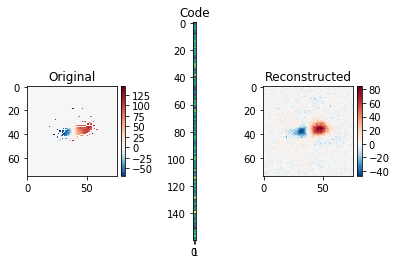

(76, 76)


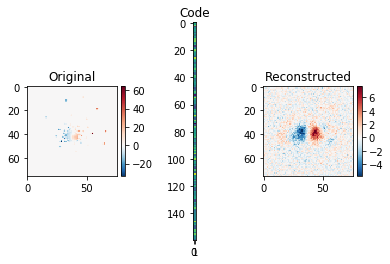

(76, 76)


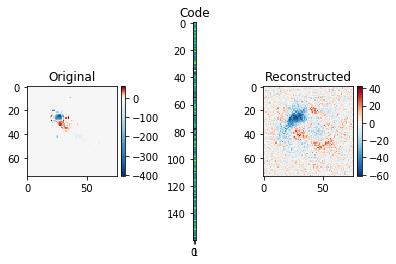

(76, 76)


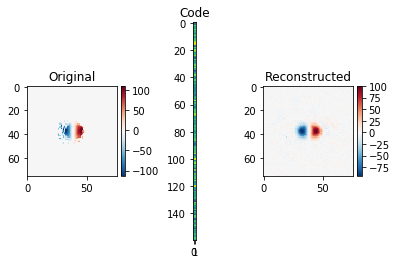

(76, 76)


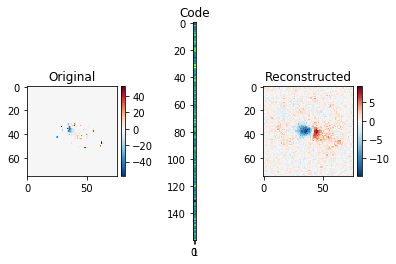

(76, 76)


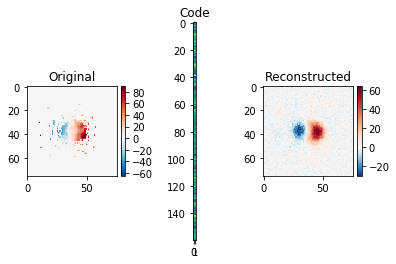

(76, 76)


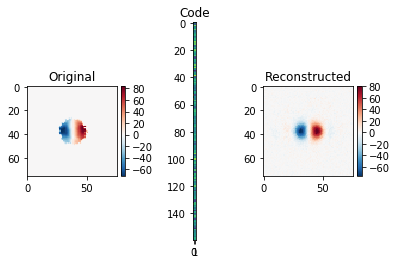

(76, 76)


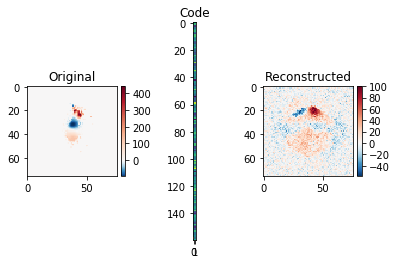

(76, 76)


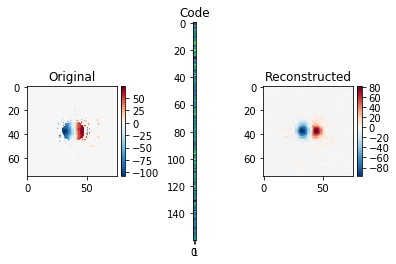

(76, 76)


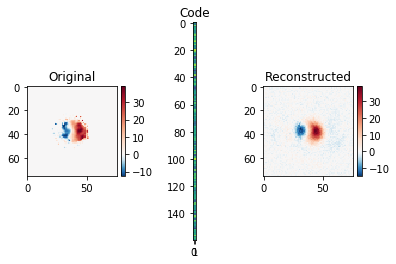

(76, 76)


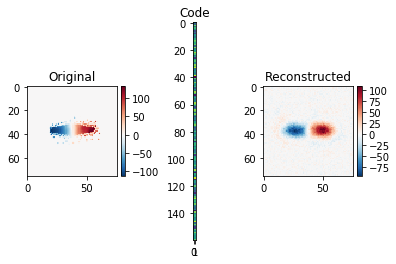

(76, 76)


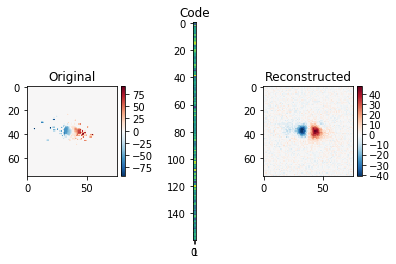

(76, 76)


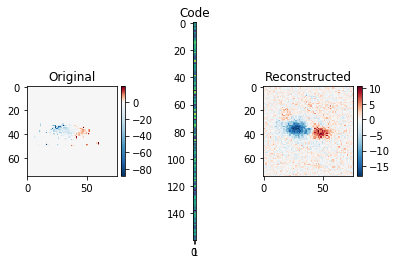

(76, 76)


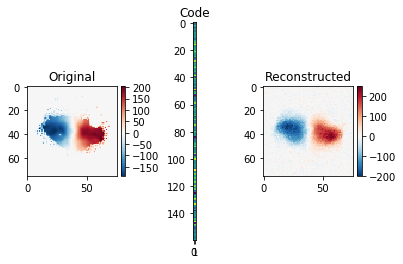

(76, 76)


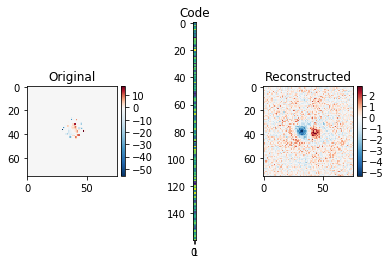

(76, 76)


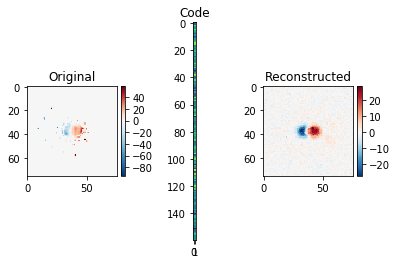

(76, 76)


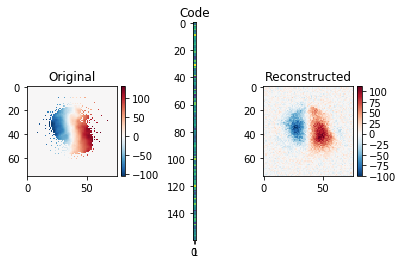

(76, 76)


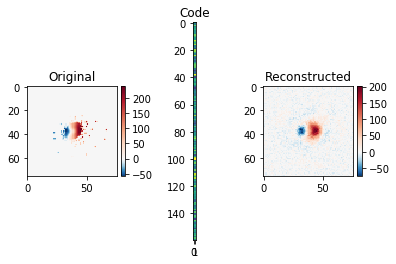

(76, 76)


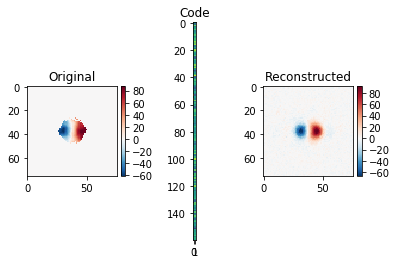

(76, 76)


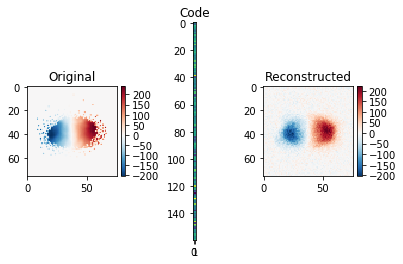

(76, 76)


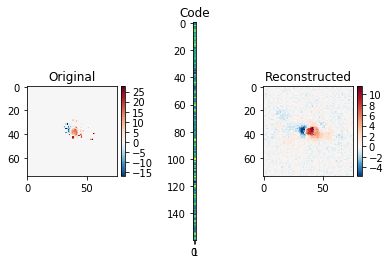

(76, 76)


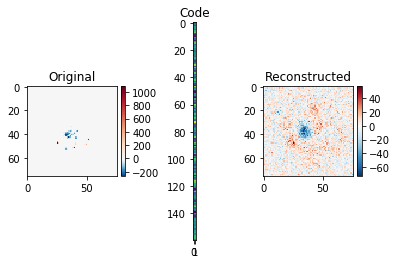

(76, 76)


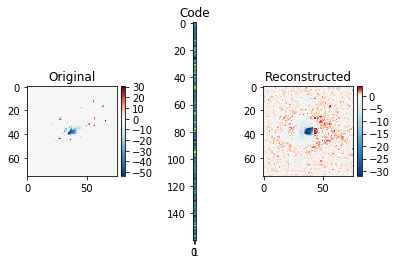

(76, 76)


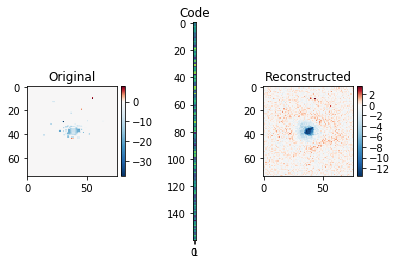

(76, 76)


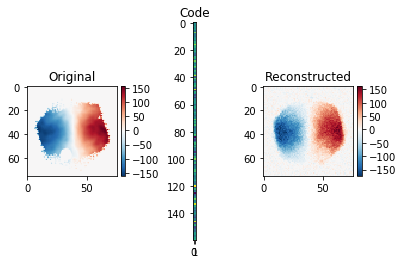

(76, 76)


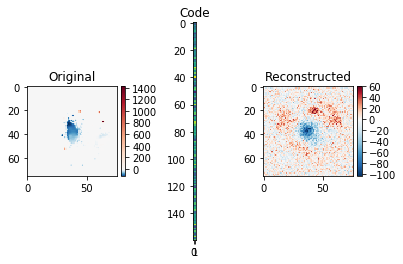

In [55]:
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


def show_image(x):
    plt.imshow(x, cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
    plt.colorbar(fraction=0.046, pad=0.04)

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(100):
    img = X_test[i]
    print(np.shape(img))
    visualize(img,encoder,decoder)


(1043, 76, 76)


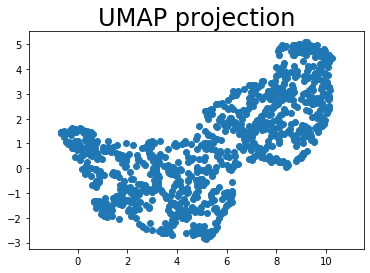

(1043, 2)


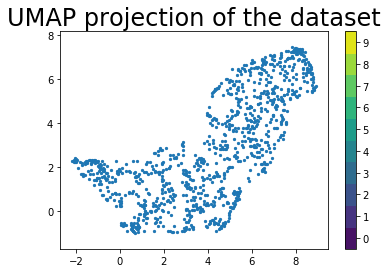

In [51]:


reconstructed=np.zeros(np.shape(full_data))
for j in range(np.shape(full_data)[0]):
    code = encoder.predict(full_data[j][None])[0]
    reco = decoder.predict(code[None])[0]
    reconstructed[j,:,:]=reco
    
    
print(np.shape(reconstructed))
reconstructed = np.reshape(reconstructed,(np.shape(reconstructed)[0], np.shape(reconstructed)[1]**2))

import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(reconstructed)

embedding.shape
plt.clf()
plt.scatter(embedding[:,0], embedding[:,1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
plt.show()
plt.clf()
# So now you can try to run a t-SNE or a UMAP on the reconstructed maps?
reducer = umap.UMAP(random_state=24)
reducer.fit(reconstructed)
embedding = reducer.transform(reconstructed)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the dataset', fontsize=24)
plt.show()

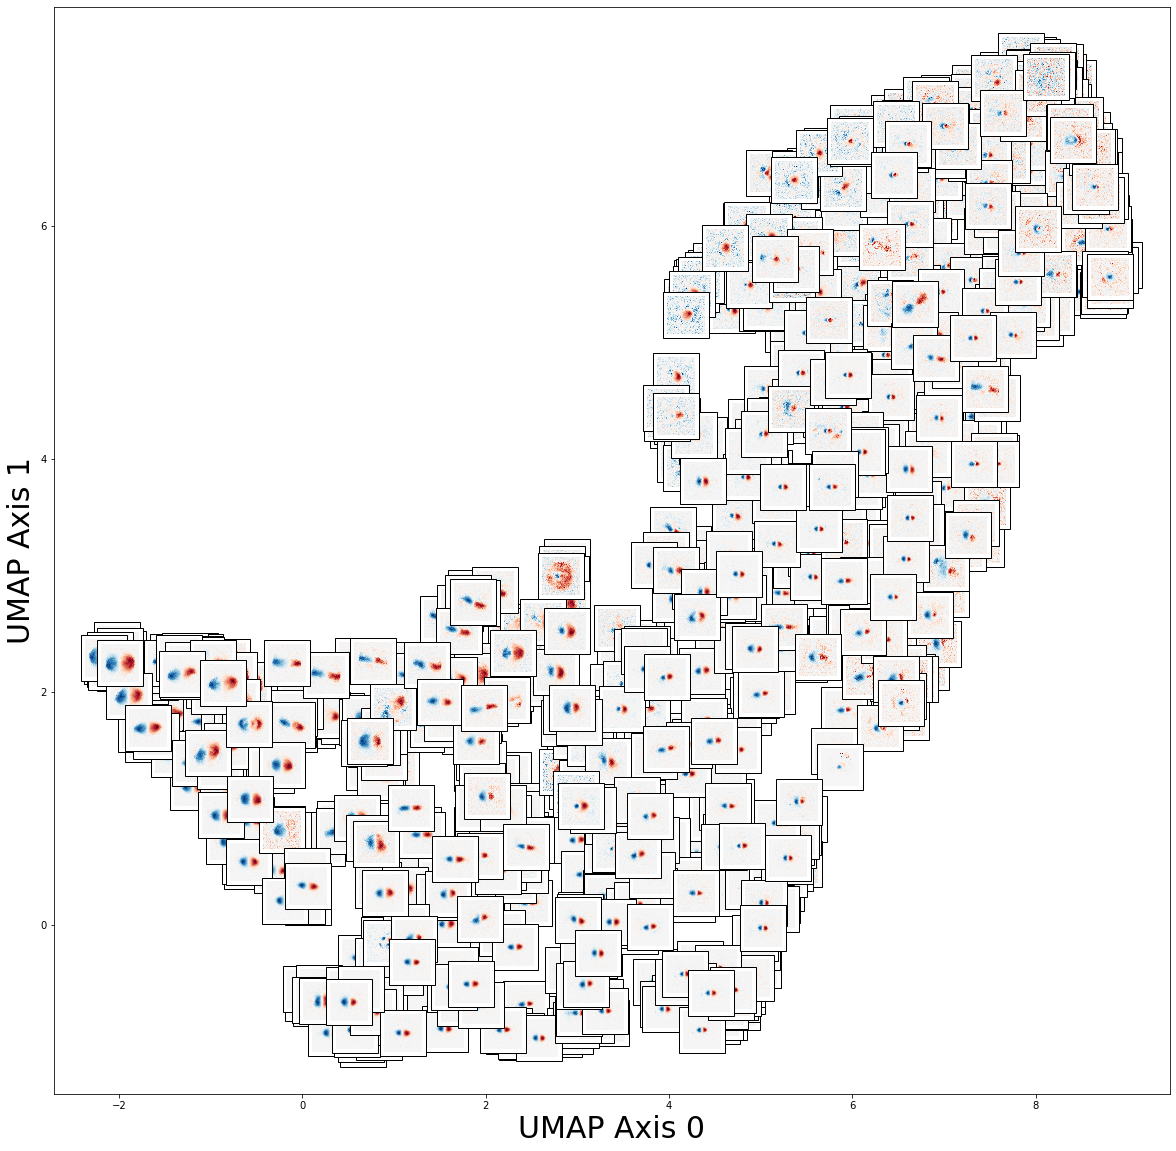

In [56]:
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
from matplotlib import pyplot as plt


class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    #elev_min=-150
    #elev_max=3000
    


# Imscatter is a cool tool that allows you to overplot
# the velocity maps as the points.
def imscatter(x, y, images, mid_val, ax=None, zoom=0.01):     
        if ax is None:         
                ax = plt.gca()           
        x, y = np.atleast_1d(x, y)     
        artists = []     
        for x0, y0, image0 in zip(x, y, images):
                ima = image0
                im = OffsetImage(ima, zoom=zoom, cmap='RdBu_r', norm=MidpointNormalize(midpoint=mid_val))   
                ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)         
                artists.append(ax.add_artist(ab))     
        ax.update_datalim(np.column_stack([x, y]))     
        ax.autoscale()     
        return artists
#np.reshape(map_array_ml[j,:],(shape,shape))
twod = np.reshape(reconstructed, (np.shape(reconstructed)[0],size, size))

fig = plt.figure(figsize=(20,20))
ax1 = plt.gca()
imscatter(embedding[:,0], embedding[:,1], np.ma.masked_where(twod==0, twod),0, 
          ax=ax1, zoom=0.5)
ax1.set_xlabel('UMAP Axis 0', size=30)
ax1.set_ylabel('UMAP Axis 1', size=30)
plt.show()
#plt.savefig('umap_ae.png')#, dpi=1000)

# It is clear that UMAP is mostly findig an orientation
# effect, AKA the biggest defining feature of this dataset
# is the orientation of the large-scale axis of rotation.
# This is unsurprising, but we'll have to remove it
# if we want to get at other trends.



1002 41


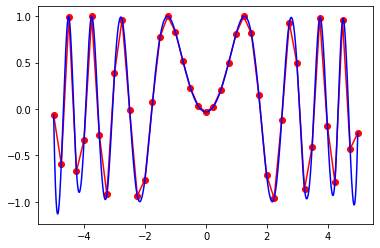

In [79]:
# What if I want everything to be the same size?
# Interpolate 
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')
#Now use the obtained interpolation function and plot the result:

xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)

print(len(xnew), len(x))
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [26]:
# Use 'conda install tensorflow' if you do not have it yet
import tensorflow as tf
#import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [28]:
## Parameters
n_inputs = 32 * 32
BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
## Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

## Print the image
with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                         batch_size: BATCH_SIZE}) 
    print(sess.run(features).shape) 
    plot_image(sess.run(features), shape=[32, 32], cmap = "Greys_r")

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [18]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28,28,1), name="input")
targets_ = tf.placeholder(tf.float32, (None, 28,28,1), name="target")

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_images(encoded, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 7x7x8
conv4 = tf.layers.conv2d(inputs=upsample1, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_images(conv4, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 14x14x8
conv5 = tf.layers.conv2d(inputs=upsample2, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_images(conv5, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 28x28x8
conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
sess = tf.Session()
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))